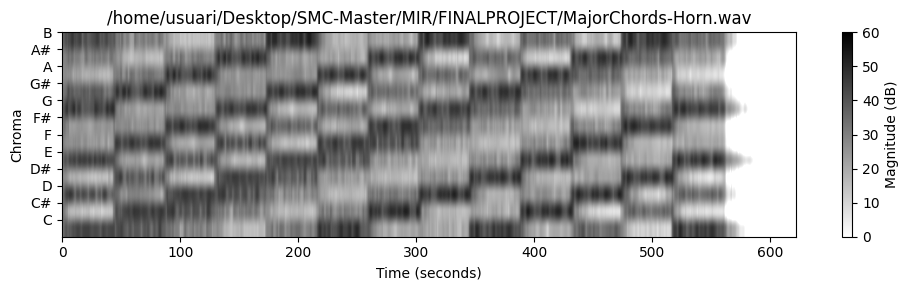

(12, 623)


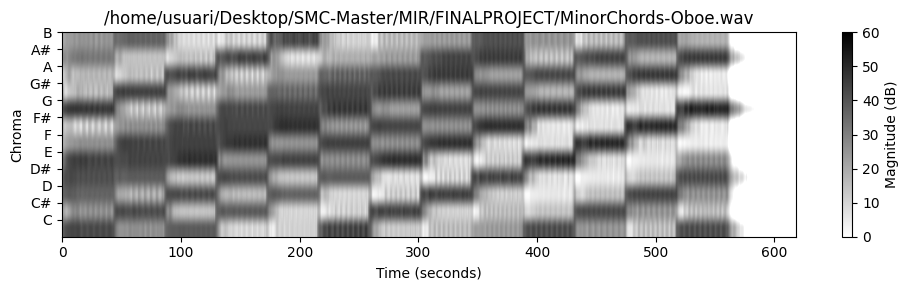

(12, 619)


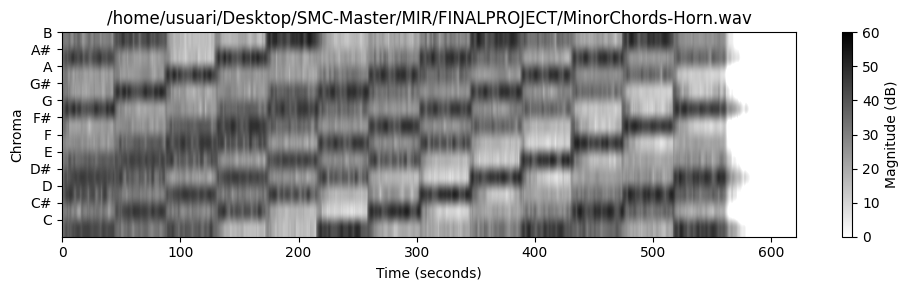

(12, 622)


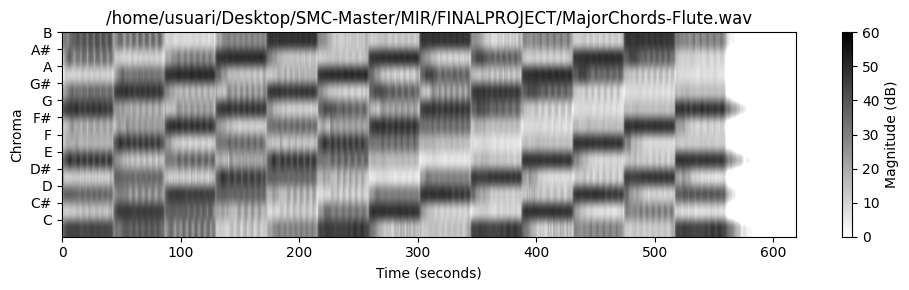

(12, 620)


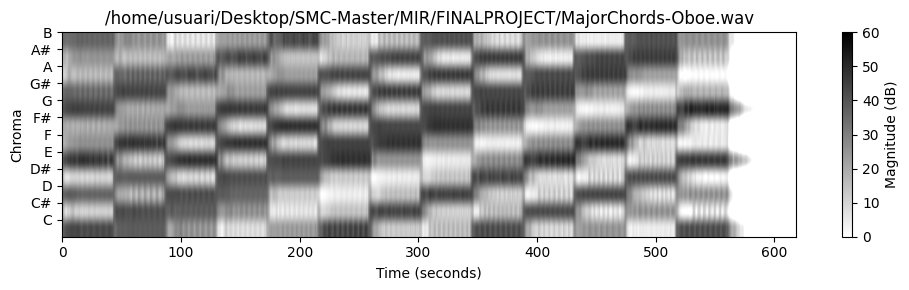

(12, 619)


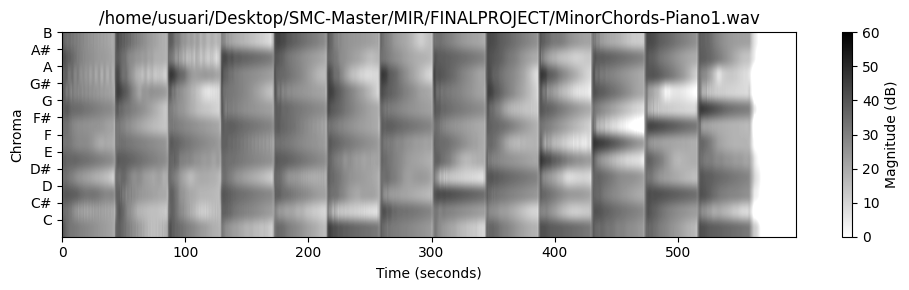

(12, 597)


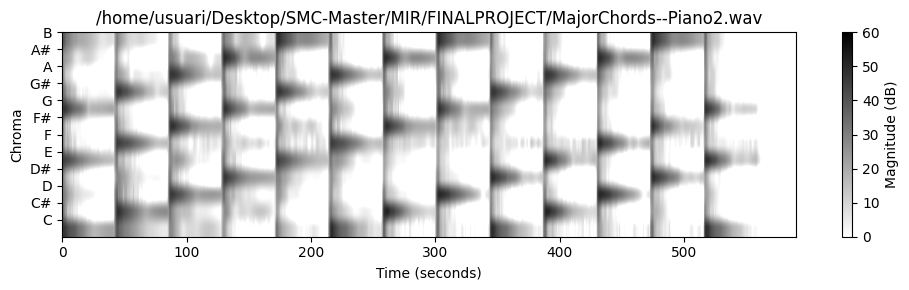

(12, 591)


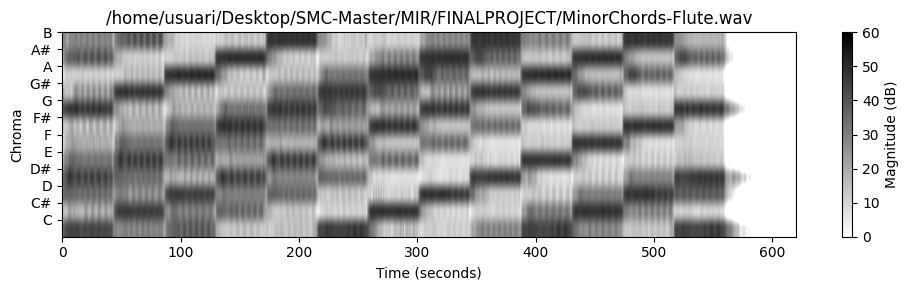

(12, 621)


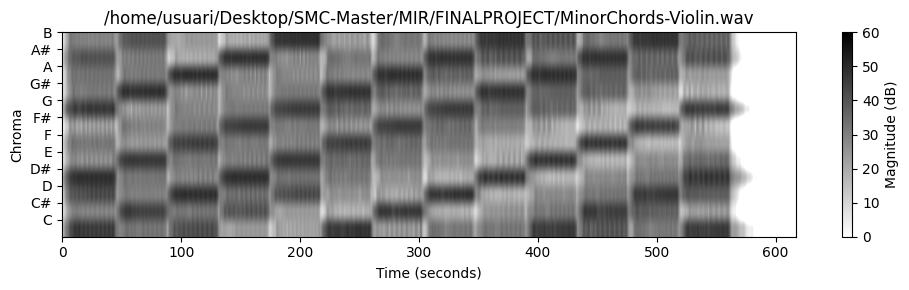

(12, 618)


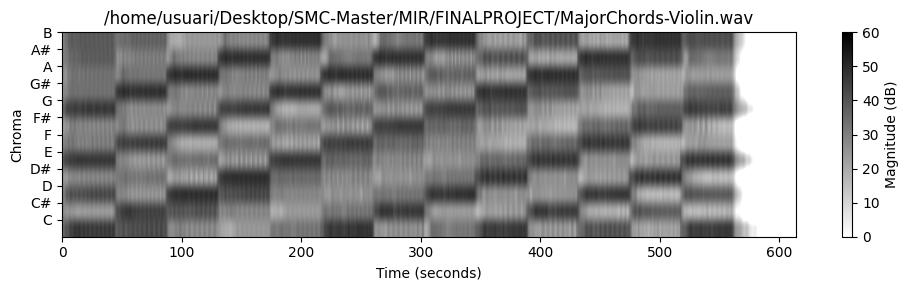

(12, 615)


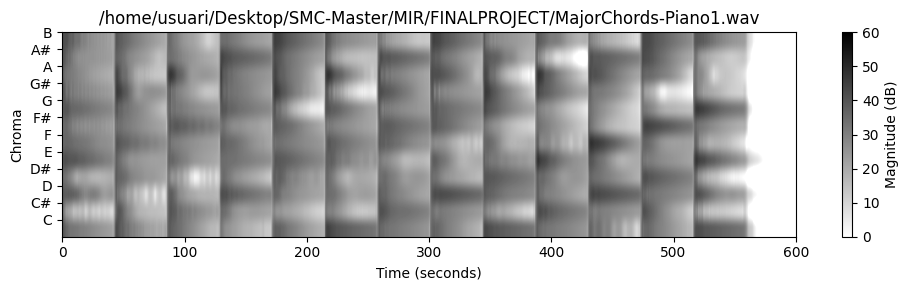

(12, 601)


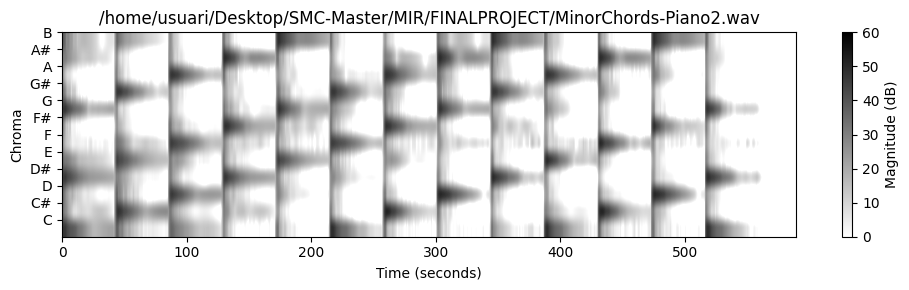

(12, 590)


In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
eps = np.finfo(float).eps

with open("chromagrams.json", "r") as f:
    chromagrams = json.load(f)

for key in chromagrams:
    chroma = np.array(chromagrams[key])

    fig = plt.figure(figsize=(10, 3))
    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    plt.imshow(10 * np.log10(eps + chroma), origin='lower', aspect='auto', cmap='gray_r')
    plt.clim([0, 60])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    cbar = plt.colorbar()
    cbar.set_label('Magnitude (dB)')
    plt.yticks(np.arange(12) + 0.5, chroma_label)
    plt.title(key)
    plt.tight_layout()
    plt.show()
    print(chroma.shape)